In [1]:
%%bash
# Install necessary Python packages
pip install spektral
pip install rdkit

# Create the directory which will contain our spektral dataset. DO NOT CHANGE
mkdir -p "/root/spektral/datasets/ProteinLigandDataset"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 651.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninstalled tensorboard-2.10.0
     ━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tens

In [2]:
#-------------------------------------------------------------------------------#
# Arrays and linear algebra
import numpy as np

# Structured data
import pandas as pd

# OS I/O
import os
import sys

# Execution timing
from time import process_time

# G/TPU tensors and neural networks
import tensorflow as tf
from tensorflow import keras

import spektral
from spektral.transforms import NormalizeAdj

# Computational biology/chemistry
import Bio
from Bio import PDB
from Bio.PDB import PDBParser

from rdkit import Chem
import rdkit

# Visualization
from matplotlib import pyplot as plt

# Nearest-neighbor searching
from scipy.spatial import KDTree

# Jupyter settings
from IPython.core.display import HTML
np.set_printoptions(precision=3, linewidth=np.inf)

# Multi-processing and -threading
import concurrent.futures
from itertools import repeat

In [3]:
# Dataset directory
DATA_DIR = "../input/ligand-dissociation-prediction/koff_dataset"

# Data Splitting
TRAIN_VAL_PROPORTION = 0.9
TRAIN_PROPORTION = TRAIN_VAL_PROPORTION * 0.8
VAL_PROPORTION = TRAIN_VAL_PROPORTION * 0.2


# Model (Hyper)-Parameters
BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 0.001
EARLY_STOP_PATIENCE = 10

In [4]:
class DataReader():
    def __init__(self, data_dir:str):
        """A data reader for processing the Koff Dataset. Reads the metadata and
        provides methods for reading ligands and proteins contain the data
        directory.
        
        Args:
          data_dir (str): The directory containing the koff_dataset
        """
        self.data_dir = data_dir
        self.structures_dir = os.path.join(self.data_dir, "initial_structure")
        self.metadata_fname = os.path.join(
            self.data_dir, "koff_index_cleaned.csv")
        self.metadata_full = pd.read_csv(self.metadata_fname)
        self.metadata = self.metadata_full[[
            "LIGAND_NAME", "K_OFF", "-LN(K_OFF)"]]
        
        # Normalize the log k_off
        self.mean = self.metadata["-LN(K_OFF)"].mean()
        self.std = self.metadata["-LN(K_OFF)"].std()
        self.metadata["-LN(K_OFF)"] = (self.metadata["-LN(K_OFF)"] - self.mean) / self.std
        
        
        # The PDBParser can be used to read any number of proteins from .pdb
        self.pdb_parser = PDBParser()
        
        # Create a dictionary of the metadata, so we can query it in O(1)
        ligand_names = self.metadata["LIGAND_NAME"]
        
        # Map bond types to integers (one-hot)
        self._bond_type_to_int = {
            "SINGLE": 1, "DOUBLE": 2, "TRIPLE": 3, "QUADRATIC": 4,"AROMATIC": 5}
        
        self._ligand_fname_to_log_koff = {
            ligand_name: koff for ligand_name, koff
            in zip(self.metadata["LIGAND_NAME"], self.metadata["-LN(K_OFF)"])}
        
    def bond_type_to_int(self, x:str):
        """Convert a bond type to an integer index.
        
        Args:
          x (str)
        Returns:
          index (int): The index for the given bond type
        """
        index = self._bond_type_to_int[x]
        return index
    
    @np.vectorize
    def _three_to_index(x:str):
        """Converts a byte-string of a 3-letter amino acid acronym to an integer
        index (one-hot)
        
        Args:
          x (str)
        Returns:
          index (int): The index of the amino acid
        """
        index = PDB.Polypeptide.three_to_index(x)
        return index
                
    def read_pdb(self, ligand_fname:str):
        """Read the associated protein in a .pdb file of a given ligand.
        
        Args:
          ligand_fname (str): The ligand file name associated with the protein
          to be queried. Ends with an extension: e.g., `.mol2`.
        Returns:
          protein (Bio.PDB.Structure.Structure): The protein structure
        """
        ligand_name, extension = os.path.splitext(ligand_fname)
        parent_dir = os.path.join(self.structures_dir, ligand_name)
        pdb_path = os.path.join(parent_dir, f"{ligand_name}_protein.pdb")
        
        protein = self.pdb_parser.get_structure(ligand_name, pdb_path)        
        return protein
    
    def read_ligand(self, ligand_fname:str):
        """Read the ligand in a .mol2 file
        
        Args:
          ligand_fname (str): The ligand file name to be queried.
        Returns:
          ligand (rdkit.Chem.Molecule): The ligand molecule
        """
        ligand_name, extension = os.path.splitext(ligand_fname)
        parent_dir = os.path.join(self.structures_dir, ligand_name)
        ligand_path = os.path.join(parent_dir, ligand_fname)
        
        ligand = Chem.MolFromMol2File(ligand_path)
        return ligand
    
    def _get_neighbor_residues(
        self,
        ligand:Chem.Mol,
        protein:Bio.PDB.Structure.Structure,
        n_neighbors:int=1,
        workers:int=1):
        """Extract the neighboring residues to each atom of a ligand. For full
        documentation on the nearest-neighbor process, see self.get_features().
        
        Args:
          ligand (rdkit.Chem.Mol)
          protein (Bio.PDB.Structure.Structure)
        
        Returns:
          residue_distances (np.ndarray): The residue distances from each
            residue. Given the array A, A[i, j] denotes the distance of the
            (j+1)^th residue-nearest-neighbor for atom i in the ligand.
          residue_names_index (np.ndarray): The corresponding residue name of
          the residue_distances.
        """
        atom_pos = np.array([
            list(ligand.GetConformer().GetAtomPosition(i))
            for i in range(ligand.GetNumAtoms())])

        residue_pos = np.array([
            residue.center_of_mass() for residue in protein.get_residues()])
        residue_names = np.array([
            residue.get_resname() for residue in protein.get_residues()])
        
        # Query a KD-tree to find the 5 nearest residues to each ligand atom
        kd_tree = KDTree(residue_pos)
        residue_distances, residue_indices = kd_tree.query(
            x=atom_pos,
            k=n_neighbors,
            workers=workers)
        
        # Extract the name of each residue from the indices
        residue_names_nearest = residue_names[residue_indices]
        residue_names_index = self._three_to_index(residue_names_nearest)
        
        return (residue_distances, residue_names_index)
        
    def _get_ligand_adjacency(self, ligand:Chem.Mol):
        """Extract the adjacency matrix for a given ligand. See
        self.get_features() for information on the adjacency matrix.
        
        Args:
          ligand (rdkit.Mol)
        Returns:
          adjacency (np.ndarray)
          edge_features (np.ndarray)
        """
        n = ligand.GetNumAtoms()
        adjacency = np.zeros((n, n), dtype=int)
        edge_features = np.zeros((n, n), dtype=int)
        
        for i, atom in enumerate(ligand.GetAtoms()):
            for atom_neighbor in atom.GetNeighbors():
                j = atom_neighbor.GetIdx()
                
                bond = ligand.GetBondBetweenAtoms(i, j)
                bond_type = str(bond.GetBondType())
                bond_type_index = self.bond_type_to_int(bond_type)
                
                adjacency[i, j] = 1
                edge_features[i, j] = bond_type_index
        
        return (adjacency, edge_features)
                
    
    def _get_ligand_atoms_names(self, ligand:Chem.Mol):
        """Extract the name (symbol) for each atom in a molecule. See
        self.get_features() for more information.
        
        Args:
          ligand (rdkit.Chem.Mol)
        Returns:
          atom_names (np.ndarray): The atom names in the form of a (n, 1) NumPy
            array, where the index of each row corresponds the atom index.
        """
        atom_names = np.array([
            atom.GetAtomicNum()
            for atom in ligand.GetAtoms()]).reshape(-1, 1)
        
        return atom_names
    
    def _get_protein_ligand_label(self, ligand_fname:str):
        """Extract the k_off values for a given protein-ligand complex. For more
        information, see the self.get_features().
        
        Args:
          ligand (str): The file name for 
        Returns:
          label (float): The k_off value corresponding to the protein-ligand
            complex.
        """
        label = self._ligand_fname_to_log_koff[ligand_fname]
        return label
    
    def get_features(self, ligand_fname:str, n_neighbors:int=2, workers:int=1):
        """Extract the adjacency matrix, node features, edge features, and
        labels for a given protein-ligand complex.
        
        The adjacency matrix, a, is given in dense form such that the first and
        second elements in a row represent a source and destination node with an
        edge between the two. The third element in a row represents the weight
        of their edge (a constant 1 for our cases).
        
        The node features matrix, x, contains a single row for each node, and a
        corresponding column for each feature. There are (1 + n_neighbors * 2)
        total node features. They are...
        (1) The ligand atom type (1 element in the feature vector)
        (2) The protein nearest neighbor distances (n_neighbors elements)
        (3) The protein nearest neighbor residue names (n_neighbors elements)
        
        The edge features matrix, e, is similar to the adjacency matrix. Instead
        of utilizing an edge weight, the edge features matrix instead provides
        an additional column for each feature in the edges. Here, we only have a
        single feature, the bond type (e.g., SINGLE, DOUBLE, TRIPLE, ...).
        
        The label, y, provides a value for the protein-ligand complex which we
        are trying to predict. The label here is the off- or dissociation-rate
        constant, `k_off`. A smaller `k_off` constant indicates that the ligand
        is more tightly bound to its protein.
        
        Args:
          ligand_fname (str): The ligand file name. We will extract both the
            protein and the associated ligand.
          n_neighbors (int): The number of nearest-protein-neighbors to query
            for each atom in the ligand.
          workers (int): The number of parallel calls to make to the KD-tree
            when querying nearest neighbors. A value of -1 maximizes the number
            of workers utilized.
        
        Returns:
          a (np.ndarray): The adjacency matrix (list)
          e (np.ndarray): The edge feature adjacency matrix (list)
          x (np.ndarray): The edge features matrix
          y (np.ndarray): The label vector
        """
        ligand = self.read_ligand(ligand_fname)
        protein = self.read_pdb(ligand_fname)
        
        atom_names = self._get_ligand_atoms_names(ligand)
        distances, names = self._get_neighbor_residues(
            ligand,
            protein,
            n_neighbors=n_neighbors,
            workers=workers
        )
        
        a, e = self._get_ligand_adjacency(ligand)
        x = np.column_stack((atom_names, distances, names))
        y = self._get_protein_ligand_label(ligand_fname)
        return (a, x, e, y)

In [5]:
class ProteinLigandDataset(spektral.data.Dataset):
    def __init__(self, data_dir:str, **kwargs):
        """Create a spektral dataset for the protein-ligand data
        """
        super().__init__(**kwargs)
        print(f"Spectral Dataset Path: {self.path}")
    
    def download_file(
        self,
        outname:str,
        a:np.ndarray,
        x:np.ndarray,
        e:np.ndarray,
        y:np.ndarray):
        """Download a file given a graph.
        
        Args:
          outname (str): The output file name the .npz file
          a (np.ndarray): The adjacency matrix
          x (np.ndarray): The node features matrix
          e (np.ndarray): The edge features matrix
          y (np.ndarray): The label vector (Potentially a NumPy scalar)
        """
        fname = os.path.join(self.path, outname)
        np.savez(fname, a=a, x=x, e=e, y=y)
        
    def download_file_from_ligand_fname(
        self,
        ligand_fname:str,
        data_reader:DataReader):
        """Process a single protein-ligand complex from a ligand file name and 
        download it onto the spektral dataset path.
        
        Args:
          ligand_fname (str): The file name of the protein-ligand complex we wish
            to process and download.
          data_reader (DataReader): The protein-ligand complex data reader

        """
        a, x, e, y = data_reader.get_features(ligand_fname)
        outname, extension = os.path.splitext(ligand_fname)
        self.download_file(outname=outname, a=a, x=x, e=e, y=y)
        
    def download_files_from_data_reader(self, data_reader:DataReader):
        """Process all protein-ligand complexes contained in the data reader.
        
        Args:
          data_reader (DataReader): The protein-ligand complex data reader
        """
        fnames = data_reader.metadata["LIGAND_NAME"]
        with concurrent.futures.ProcessPoolExecutor() as executor:
            executor.map(
                self.download_file_from_ligand_fname,
                fnames,
                repeat(data_reader)
            )
        
    def read(self):
        fnames = (
            os.path.join(self.path, fname)
            for fname in os.listdir(self.path)
            if fname.endswith(".npz"))
        
        output = []
        for fname in fnames:
            data = np.load(fname)
            graph = spektral.data.Graph(
                x=data["x"],
                a=data["a"],
                y=data["y"])
            output.append(graph)
        
        return output

In [6]:
data_reader = DataReader(DATA_DIR)
data_reader.metadata.head(20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,LIGAND_NAME,K_OFF,-LN(K_OFF)
0,3hec_ligand_native_1.mol2,0.380000,-1.087683
1,3heg_ligand_native_2.mol2,0.018000,-0.169185
2,1kv2_ligand_native_3.mol2,0.000008,2.144341
3,1kv1_ligand_native_4.mol2,0.062000,-0.541657
4,3gcq_ligand_native_5.mol2,0.036848,-0.384948
5,3gcv_ligand_native_6.mol2,0.009739,0.015787
6,3d83_ligand_native_10.mol2,0.008400,0.060347
7,3d7z_ligand_native_11.mol2,0.023000,-0.243007
8,3gcp_ligand_native_12.mol2,0.016000,-0.133712
9,2yiw_ligand_native_16.mol2,0.000040,1.670719


In [7]:
dataset = ProteinLigandDataset(DATA_DIR)

Spectral Dataset Path: /root/spektral/datasets/ProteinLigandDataset


In [8]:
dataset.download_files_from_data_reader(data_reader)
dataset = ProteinLigandDataset(DATA_DIR)

/opt/conda/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5825
  PDBConstructionWarning,
[22:21:25] 4mzn_ligand_native_34.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[22:21:25] 5jt9_ligand_native_35.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[22:21:25] 5js3_ligand_native_36.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[22:21:25] 5jvi_ligand_native_37.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[22:21:25] 5jss_ligand_native_38.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[22:21:25] 5lwd_ligand_1_39_dock.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[22:21:25] 5lwd_ligand_3_41_dock.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[22:21:25] 5lwd_ligand_4_42_dock.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[22:21:25] 5lwd_ligand_2_40_dock.mol2: warning - O.co2 with non C.2 or S.o2 neighbor.
[22:21:25] 5lif_ligand_native_43.mol2: warning - O.co2 with non

Spectral Dataset Path: /root/spektral/datasets/ProteinLigandDataset


In [9]:
# Extract training, testing, and validation data
n_graphs = len(dataset)

train_size = int(n_graphs * TRAIN_PROPORTION)
val_size = int(n_graphs * VAL_PROPORTION)

np.random.shuffle(dataset)
data_train = dataset[0:train_size]
data_val = dataset[train_size:train_size+val_size]
data_test = dataset[train_size+val_size:]

print(f"""\
Graph Size: {n_graphs}
Train Size: {len(data_train)}
Val Size:   {len(data_val)}
Test Size:  {len(data_test)}\
""")

Graph Size: 530
Train Size: 381
Val Size:   95
Test Size:  54


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: you are shuffling a 'ProteinLigandDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  import sys


In [10]:
# Define loaders for getting batches of graphs
data_train_loader = spektral.data.DisjointLoader(
    data_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)

data_val_loader = spektral.data.DisjointLoader(
    data_val,
    batch_size=BATCH_SIZE)

data_test_loader = spektral.data.DisjointLoader(
    data_test,
    batch_size=BATCH_SIZE)

In [11]:
class GNN(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = spektral.layers.GCSConv(32, activation="leaky_relu")
        self.conv2 = spektral.layers.GCSConv(32, activation="leaky_relu")
        self.global_pool = spektral.layers.GlobalAvgPool()
        self.dense = keras.layers.Dense(1, activation=None)
        
    def call(self, inputs):
        x, a, i = inputs
        
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.global_pool([x, i])
        output = self.dense(x)
        return output

In [12]:
model = GNN()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_function = keras.losses.MeanSquaredError()

2022-10-05 22:22:05.876432: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
@tf.function(input_signature=data_train_loader.tf_signature(),
             experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_function(target, predictions) + sum(model.losses)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def evaluate(loader:spektral.data.Loader):
    output = []
    step = 0
    
    while step < loader.steps_per_epoch:
        step += 1
        
        inputs, target = next(loader)
        predictions = model(inputs, training=False)
        
        loss = loss_function(target, predictions)
        loss_average = np.mean(loss)
        output.append(loss_average)
    
    output = np.mean(output)
    return output

In [14]:
epoch = 0
step = 0

best_val_loss = np.inf
best_weights = None

patience = EARLY_STOP_PATIENCE
results = []
epoch_loss = []
epoch_val_loss = []

for batch in data_train_loader:
    step += 1
    loss = train_step(*batch)
    results.append(loss)
    
    if step == data_train_loader.steps_per_epoch:
        step = 0
        epoch += 1
        
        val_loss = evaluate(data_val_loader)
        print(f"Epoch: {epoch} - Loss:{np.mean(results)} - Val Loss: {val_loss}")
        epoch_loss.append(np.mean(results))
        epoch_val_loss.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = EARLY_STOP_PATIENCE
            best_weights = model.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print(f"Early Stopping (Best Val Loss: {best_val_loss})")
                break
        
        results = []

/opt/conda/lib/python3.7/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'ProteinLigandDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  return py_builtins.overload_of(f)(*args)
2022-10-05 22:22:07.520897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/spektral/layers/convolutional/conv.py:99: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features 

Epoch: 1 - Loss:5.011598110198975 - Val Loss: 1.259455680847168
Epoch: 2 - Loss:1.6063032150268555 - Val Loss: 1.2417455911636353
Epoch: 3 - Loss:1.7023011445999146 - Val Loss: 1.5571017265319824
Epoch: 4 - Loss:1.850730299949646 - Val Loss: 1.0634711980819702
Epoch: 5 - Loss:2.3905718326568604 - Val Loss: 1.3143917322158813
Epoch: 6 - Loss:1.624442219734192 - Val Loss: 0.8168342113494873
Epoch: 7 - Loss:1.2198175191879272 - Val Loss: 1.3677574396133423
Epoch: 8 - Loss:2.0016214847564697 - Val Loss: 1.4817477464675903
Epoch: 9 - Loss:1.7822937965393066 - Val Loss: 1.2957597970962524
Epoch: 10 - Loss:1.3130747079849243 - Val Loss: 1.0194511413574219
Epoch: 11 - Loss:1.3222931623458862 - Val Loss: 1.0905150175094604
Epoch: 12 - Loss:1.2458797693252563 - Val Loss: 0.9431570172309875
Epoch: 13 - Loss:1.0621556043624878 - Val Loss: 1.2726891040802002
Epoch: 14 - Loss:1.2403106689453125 - Val Loss: 1.255763053894043
Epoch: 15 - Loss:1.4323192834854126 - Val Loss: 1.6295666694641113
Epoch: 16

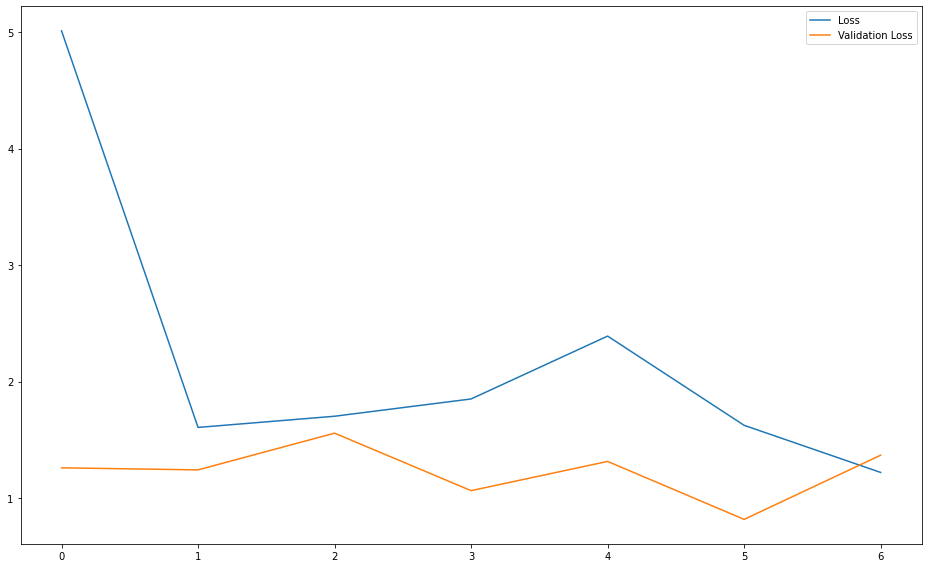

In [15]:
loss = np.array(epoch_loss)[:-EARLY_STOP_PATIENCE+1]
val_loss = np.array(epoch_val_loss)[:-EARLY_STOP_PATIENCE+1]

fig, ax = plt.subplots(figsize=(13, 8), tight_layout=True)
ax.plot(loss, label="Loss")
ax.plot(val_loss, label="Validation Loss")
ax.legend()